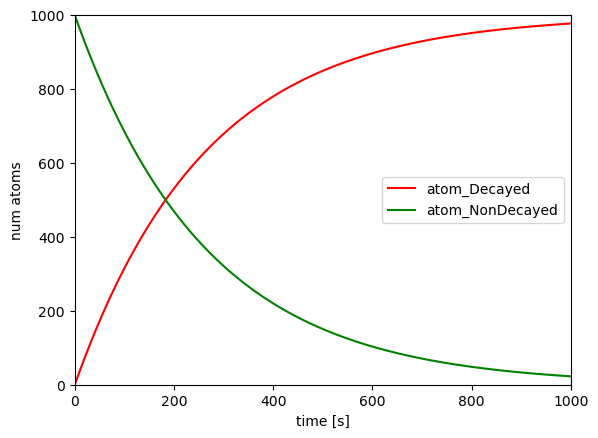

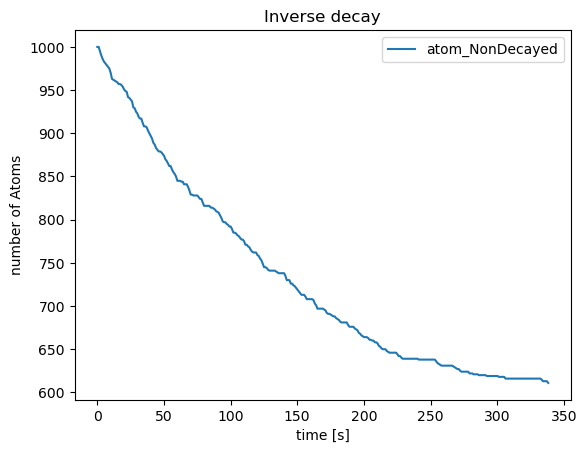

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

tau = 3.052 * 60
N = 1000

def decay(t):
    return N * (1 - 2 ** (-t / tau))

t = np.linspace(0, 1000, 1000)
plt.plot(t, decay(t), color='r', label='atom_Decayed')
plt.plot(t, N - decay(t), color='g', label='atom_NonDecayed')
plt.xlabel('time [s]')
plt.ylabel('num atoms')
plt.axis([0, 1000, 0, 1000])
plt.legend()
plt.show()

def inverse_decay(Num, tau):
    t = -tau * np.log(1 - Num) / np.log(2)
    return t

y = np.random.random(1000)
w = np.sort(inverse_decay(y, tau))

time = np.linspace(0, 1000, 1000)
A = np.zeros(1000)
Index = 0

for j in range(1000):
    if w[j] < time[Index]:
        A[Index] += 1
    else:
        Index += 1

total = np.sum(A)
f = 0
T = []
while np.sum(A[:f]) < total:
    T.append(np.sum(A[:f]))
    f += 1

decayed = np.asarray(T)
nondecayed = N - decayed

plt.plot(time[:f], nondecayed, label='atom_NonDecayed')
plt.xlabel('time [s]')
plt.ylabel('number of Atoms')
plt.title('Inverse decay')
plt.legend()
plt.show()


0.0029687486578378053
1.3496316716069763
0.0020661976209009397


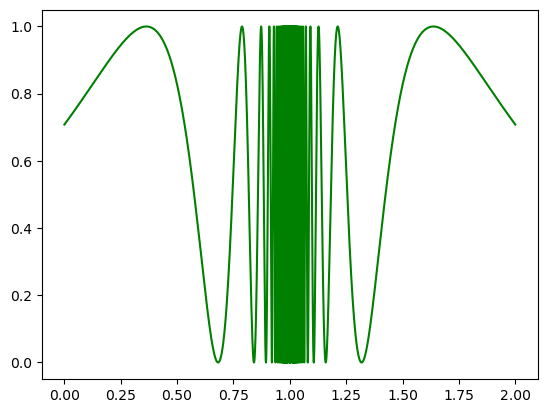

In [8]:
#Q2
def f(x):
    return (np.sin(1/(1-x)))**2

x=np.linspace(0.00001,1.99999,100000)
plt.plot(x,f(x),color = "green")
N = 99999
count=0
for i in range(N):
    x=2*np.random.random() 
    y=np.random.random()
    if y<f(x): 
        count+=1
        
err = (1-(-1))*np.sqrt(N*(count/N)*(1-count/N))/N
print( err)


x = np.zeros(N)
y = np.zeros(N)
for i in range(N):
    x[i] = 2*np.random.random()  
    y[i] = f(x[i])  

I = ((1-(-1))*np.sum(y))/N

first = (1/N)*np.sum(y**2)
second= (1/N)*np.sum(y)

err_mean = ((1-(-1))*np.sqrt((first-second**2)/N))
    
print(I)
print(err_mean)



In [9]:
#Q3
N=99999
first=0
dimension = 2
for i in range(N): 
    x=2*np.random.random()-1 
    y=2*np.random.random()-1 
    if x**2+y**2<=1:
        first+=1
        
area_circle = ((2**dimension)/N)*count
print(area_circle)        
        
dimension = 10

def dim10():
    second=0
    for i in range(N):
        R=0
        for j in range (dimension):
            R+=((np.random.random())**2)
        if (R<=1):
            second+=1
    return (2**10)*(second/N)
print(dim10())

2.6889468894688946
2.4064240642406425


In [10]:
#Q4
def I(x):
    return (x**(-0.5))/(np.exp(x)+1) 
def w(x):
    return 1/(np.sqrt(x)) 

a=0
b=1
N=1000
first=True

for i in range(N):
    v= np.random.uniform(a, b)**2 
    if first:
        f1 = np.array([I(v)])
        w1 = np.array([w(v)])
        first = False
    else:
        f1 = np.append(f1, I(v))
        w1 = np.append(w1, w(v))
        
I = 2*sum(f1/w1)/N
print(I)

0.8449248537998887
